--- Starting Comparative Analysis: GLiNER vs. Qwen (Violin Plot with Data Points) ---
Step 1: Loading and processing data...
Step 2: Combining data...
Step 3: Generating the prettified grouped violin plot...


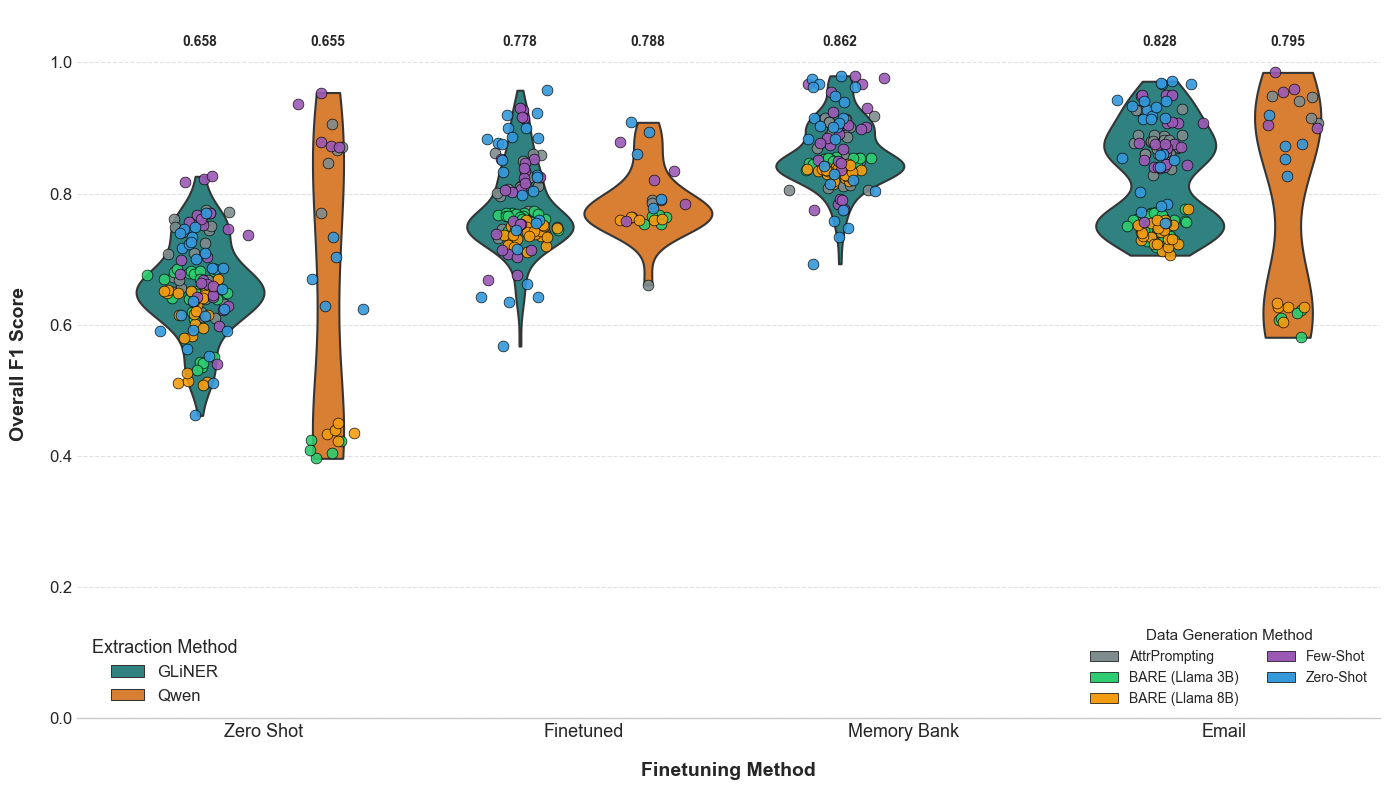


Plot successfully generated and saved as 'summary_comparison_qwen_gliner_enhanced'
Data generation methods found: ['AttrPrompting', 'BARE (Llama 3B)', 'BARE (Llama 8B)', 'Few-Shot', 'Zero-Shot']


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')

def create_grouped_violin_plot_with_dots():
    """
    Loads, processes, and combines GLiNER and Qwen results to generate a polished,
    grouped violin plot with semi-transparent bodies and overlaid raw data points.
    """
    # -------------------------------------------------------------------
    # Data Loading
    # -------------------------------------------------------------------
    try:
        df_gliner = pd.read_csv("../gliner_evaluation/results/gliner_eval_full.csv")
        df_qwen = pd.read_csv("../llm_finetuning/eval_results/qwen_results_full.csv")
    except FileNotFoundError as e:
        print(f"Error: A data file was not found. Please check the path.\n{e}")
        return

    base_models = ['gliner_base', 'gliner_sbert', 'gliner_bge', 'gliner_simcse', 'gliner_mlm']
    finetuned_models = ['gliner_finetuned', 'gliner_finetued_sbert', 'gliner_finetuned_sbert', 'gliner_finetuned_bge', 'gliner_finetuned_simcse', 'gliner_finetuned_mlm']
    memory_bank_models = ['gliner_base_entity_aware', 'gliner_sbert_entity_aware', 'gliner_bge_entity_aware', 'gliner_simcse_entity_aware', 'gliner_mlm_entity_aware']
    email_models = ['gliner_finetuned_email', 'gliner_sbert_finetuned_email', 'gliner_finetuned_bge_email', 'gliner_finetuned_simcse_email', 'gliner_finetuned_mlm_email']

    def get_gliner_model_type(model_name):
        if model_name in base_models: return 'Zero Shot'
        if model_name in finetuned_models: return 'Finetuned'
        if model_name in memory_bank_models: return 'Memory Bank'
        if model_name in email_models: return 'Email'
        return 'Unknown'

    def get_data_generation_method(dataset_name):
        """Extract data generation method from dataset name"""
        if pd.isna(dataset_name):
            return 'Unknown'
        if 'attr_prompting' in dataset_name:
            return 'AttrPrompting'
        elif 'bare_llama_3b' in dataset_name:
            return 'BARE (Llama 3B)'
        elif 'bare_llama_8b' in dataset_name:
            return 'BARE (Llama 8B)'
        elif 'fewshot' in dataset_name:
            return 'Few-Shot'
        elif 'zero_shot' in dataset_name or dataset_name == 'base':
            return 'Zero-Shot'
        else:
            return 'Zero-Shot'

    df_gliner['overall_f1'] = df_gliner[['vessel_f1', 'port_f1', 'commodity_f1', 'incoterm_f1']].mean(axis=1)
    df_gliner['finetuning_type'] = df_gliner['model'].apply(get_gliner_model_type)
    if 'dataset' in df_gliner.columns:
        df_gliner['data_generation'] = df_gliner['dataset'].apply(get_data_generation_method)
    else:
        df_gliner['data_generation'] = df_gliner['finetuning_type']
    df_gliner['method'] = 'GLiNER'
    gliner_processed = df_gliner[['method', 'finetuning_type', 'data_generation', 'overall_f1']]

    def get_qwen_model_type(model_name):
        if 'base' in model_name: return 'Zero Shot'
        if 'finetuned' in model_name and 'email' not in model_name: return 'Finetuned'
        if 'email' in model_name: return 'Email'
        return 'Unknown'

    df_qwen['overall_f1'] = df_qwen[['vessel_f1', 'port_f1', 'commodity_f1', 'incoterm_f1']].mean(axis=1)
    df_qwen['finetuning_type'] = df_qwen['model'].apply(get_qwen_model_type)
    if 'dataset' in df_qwen.columns:
        df_qwen['data_generation'] = df_qwen['dataset'].apply(get_data_generation_method)
    else:
        df_qwen['data_generation'] = df_qwen['finetuning_type']
    df_qwen['method'] = 'Qwen'
    qwen_processed = df_qwen[['method', 'finetuning_type', 'data_generation', 'overall_f1']]

    # -------------------------------------------------------------------
    # Combining DataFrames for Plotting
    # -------------------------------------------------------------------
    print("Step 2: Combining data...")
    df_combined = pd.concat([gliner_processed, qwen_processed], ignore_index=True)
    finetuning_order = ['Zero Shot', 'Finetuned', 'Memory Bank', 'Email']
    df_combined = df_combined[df_combined['finetuning_type'].isin(finetuning_order)]

    # -------------------------------------------------------------------
    # Grouped Violin Plots Generation
    # -------------------------------------------------------------------
    print("Step 3: Generating the prettified grouped violin plot...")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))

    custom_palette = {'GLiNER': '#21908dff', 'Qwen': '#f57d18ff'}

    generation_palette = {
        'Zero-Shot': '#3498db',     
        'Zero Shot': '#3498db',          
        'Attribute Prompting': '#e74c3c',
        'BARE (Llama 3B)': '#2ecc71',
        'BARE (Llama 8B)': '#f39c12',
        'Few-Shot': '#9b59b6',
        'Finetuned': '#e74c3c',
        'Memory Bank': '#16a085',
        'Email': '#e67e22'
    }

    sns.violinplot(
        data=df_combined,
        x='finetuning_type',
        y='overall_f1',
        hue='method',
        order=finetuning_order,
        hue_order=['GLiNER', 'Qwen'],
        palette=custom_palette,
        ax=ax,
        split=False,
        dodge=True,
        inner=None,
        linewidth=1.5,
        alpha=0.2,
        cut=0
    )

    for i, finetuning_type in enumerate(finetuning_order):
        for j, method in enumerate(['GLiNER', 'Qwen']):
            position_offset = -0.2 if j == 0 else 0.2
            position = i + position_offset

            subset = df_combined[(df_combined['finetuning_type'] == finetuning_type) &
                               (df_combined['method'] == method)]

            if not subset.empty:
                for data_gen in subset['data_generation'].unique():
                    data_subset = subset[subset['data_generation'] == data_gen]

                    x_positions = np.random.normal(position, 0.05, size=len(data_subset))

                    color = generation_palette.get(data_gen, '#7f8c8d')

                    ax.scatter(x_positions, data_subset['overall_f1'],
                              color=color,
                              alpha=0.9,
                              s=60,
                              edgecolors='black',
                              linewidth=0.5,
                              label=data_gen if (i == 0 and j == 0 and data_gen not in [l.get_label() for l in ax.collections[2:]]) else "")

    for i, finetuning_type in enumerate(finetuning_order):
        for j, method in enumerate(['GLiNER', 'Qwen']):
            position = i - 0.2 if j == 0 else i + 0.2

            subset = df_combined[(df_combined['finetuning_type'] == finetuning_type) & (df_combined['method'] == method)]
            if not subset.empty:
                mean_val = subset['overall_f1'].mean()
                ax.text(position, 1.02, f'{mean_val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_xlabel('Finetuning Method', fontsize=14, fontweight='bold', labelpad=15)
    ax.set_ylabel('Overall F1 Score', fontsize=14, fontweight='bold', labelpad=15)
    ax.set_ylim(0, 1.08)
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(axis='x', linestyle='', which='both')
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    handles, labels = ax.get_legend_handles_labels()

    legend1 = ax.legend(handles[0:2], labels[0:2], title='Extraction Method',
                       fontsize=12, title_fontsize=13, loc='lower left', frameon=False)

    ax.add_artist(legend1)

    unique_data_gen = sorted(df_combined['data_generation'].unique())
    from matplotlib.patches import Patch
    generation_handles = [Patch(facecolor=generation_palette.get(gen, '#7f8c8d'),
                               edgecolor='black',
                               linewidth=0.5, label=gen) for gen in unique_data_gen]
    ax.legend(handles=generation_handles, title='Data Generation Method',
             fontsize=10, title_fontsize=11, loc='lower right', frameon=False,
             ncol=2)

    sns.despine(ax=ax, left=True)

    plt.tight_layout()
    output_filename = 'summary_comparison_qwen_gliner_enhanced'
    plt.savefig(output_filename, dpi=300)
    plt.show()

if __name__ == '__main__':
    create_grouped_violin_plot_with_dots()